In [2]:
# Josh Burgess
# 300652214

import os
from sklearn.model_selection import train_test_split
import random

In [3]:
# Validation set was deemed too small
# I will combine og train + val, then create proper 80/20 split

def create_splits():
    
    # All training images
    train_normal = "chest_xray/train/NORMAL"
    train_pneumonia = "chest_xray/train/PNEUMONIA"
    val_normal = "chest_xray/val/NORMAL" 
    val_pneumonia = "chest_xray/val/PNEUMONIA"
    
    # File paths
    normal_files = []
    pneumonia_files = []
    
    # Add og train files
    for f in os.listdir(train_normal):
        normal_files.append(os.path.join(train_normal, f))

    for f in os.listdir(train_pneumonia):
        pneumonia_files.append(os.path.join(train_pneumonia, f))
        
    # Add og val files  
    for f in os.listdir(val_normal):
        normal_files.append(os.path.join(val_normal, f))

    for f in os.listdir(val_pneumonia):
        pneumonia_files.append(os.path.join(val_pneumonia, f))
    
    print(f"Total Normal: {len(normal_files)}")
    print(f"Total Pneumonia: {len(pneumonia_files)}")
    
    return normal_files, pneumonia_files

normal_files, pneumonia_files = create_splits()

Total Normal: 1349
Total Pneumonia: 3883


In [4]:
# Create 80/20 Split
# Split normal images
normal_train, normal_val = train_test_split(normal_files, test_size=0.2, random_state=42)

# Split pneumonia images  
pneumonia_train, pneumonia_val = train_test_split(pneumonia_files, test_size=0.2, random_state=42)

print("New split sizes:")
print(f"Train: Normal={len(normal_train)}, Pneumonia={len(pneumonia_train)}")
print(f"Val: Normal={len(normal_val)}, Pneumonia={len(pneumonia_val)}")
print(f"Test: Unchanged (Normal=234, Pneumonia=390)")

New split sizes:
Train: Normal=1079, Pneumonia=3106
Val: Normal=270, Pneumonia=777
Test: Unchanged (Normal=234, Pneumonia=390)


**Image Preprocessing Pipeline**

In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [6]:
"""
Preprocesses image: resize + padding to square, convert to tensor
Maintains aspect ratio and preserves anatomical information
"""

def preprocess_image(image_path, target_size=224):

    # Load image
    img = Image.open(image_path)
    
    # Convert to RGB 
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Get og dimensions
    original_width, original_height = img.size
    
    # Calc new size maintaining aspect ratio
    if original_width > original_height:
        new_width = target_size
        new_height = int((target_size * original_height) / original_width)
        
    else:
        new_height = target_size
        new_width = int((target_size * original_width) / original_height)
    
    # Resize maintaining aspect ratio
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create new square image with black padding
    new_img = Image.new('RGB', (target_size, target_size), (0, 0, 0))
    
    # Center the resized image
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2
    new_img.paste(img, (x_offset, y_offset))
    
    return new_img

In [7]:
# Test preprocessing on sample images
sample_normal = normal_files[0]  # Use first normal image from list
sample_pneumonia = pneumonia_files[0]  # Use first pneumonia image from list

print(f"Testing with:")
print(f"Normal: {sample_normal}")
print(f"Pneumonia: {sample_pneumonia}")

# Load and preprocess
original_normal = Image.open(sample_normal)
processed_normal = preprocess_image(sample_normal)

original_pneumonia = Image.open(sample_pneumonia)
processed_pneumonia = preprocess_image(sample_pneumonia)

print(f"\nOriginal sizes:")
print(f"Normal: {original_normal.size}")
print(f"Pneumonia: {original_pneumonia.size}")

print(f"\nProcessed sizes:")
print(f"Normal: {processed_normal.size}")
print(f"Pneumonia: {processed_pneumonia.size}")

Testing with:
Normal: chest_xray/train/NORMAL\IM-0115-0001.jpeg
Pneumonia: chest_xray/train/PNEUMONIA\person1000_bacteria_2931.jpeg

Original sizes:
Normal: (2090, 1858)
Pneumonia: (1152, 760)

Processed sizes:
Normal: (224, 224)
Pneumonia: (224, 224)


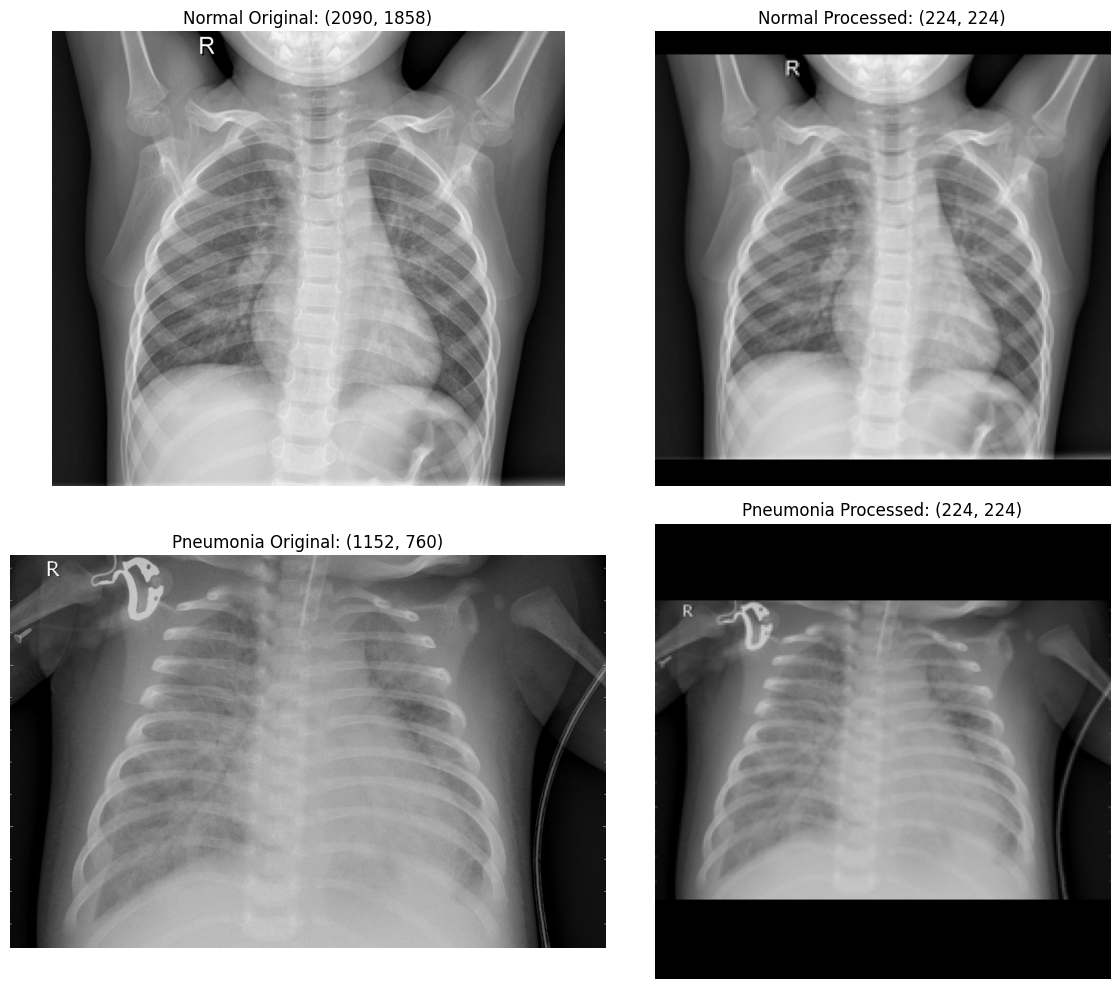

In [8]:
# Visualise the preprocessing results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Normal image - before and after
axes[0,0].imshow(original_normal, cmap='gray')
axes[0,0].set_title(f'Normal Original: {original_normal.size}')
axes[0,0].axis('off')

axes[0,1].imshow(processed_normal)
axes[0,1].set_title(f'Normal Processed: {processed_normal.size}')
axes[0,1].axis('off')

# Pneumonia image - before and after  
axes[1,0].imshow(original_pneumonia, cmap='gray')
axes[1,0].set_title(f'Pneumonia Original: {original_pneumonia.size}')
axes[1,0].axis('off')

axes[1,1].imshow(processed_pneumonia)
axes[1,1].set_title(f'Pneumonia Processed: {processed_pneumonia.size}')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Preprocessing pipeline with augmentation
def get_transforms():
    # Returns train and val transforms
    
    # Training transforms (with augmentation)
    train_transform = transforms.Compose([
        transforms.Lambda(lambda x: preprocess_image(x) if isinstance(x, str) else x),
        transforms.RandomRotation(10),  # ±10° rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # ±20% brightness/contrast
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
    ])
    
    # Validation transforms (no augmentation to provide consistent repeatable evaluation)
    val_transform = transforms.Compose([
        transforms.Lambda(lambda x: preprocess_image(x) if isinstance(x, str) else x),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

train_transforms, val_transforms = get_transforms()


**PyTorch Dataset Class**

Used to more effectively feed data into the models

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch

In [11]:
"""
Custom dataset for chest X-ray images
normal_files: List of file paths to normal X-ray images
pneumonia_files: List of file paths to pneumonia X-ray images  
transform: PyTorch transforms to apply to images
"""

class ChestXrayDataset(Dataset):
    
    def __init__(self, normal_files, pneumonia_files, transform=None):
    
        # Combine file paths and create corresponding labels
        # Creates dataset that is unified
        self.image_paths = normal_files + pneumonia_files
        self.labels = [0] * len(normal_files) + [1] * len(pneumonia_files)  # 0=Normal, 1=Pneumonia
        self.transform = transform
    
    def __len__(self):
        # Return total number of images
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Get a single image and its label
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load and preprocess image
        image = preprocess_image(image_path)
        
        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [12]:
# Create datasets using train/val splits
train_dataset = ChestXrayDataset(normal_train, pneumonia_train, transform=train_transforms)
val_dataset = ChestXrayDataset(normal_val, pneumonia_val, transform=val_transforms)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Test loading a single sample
sample_image, sample_label = train_dataset[0]
print(f"\nSample image shape: {sample_image.shape}")
print(f"Sample label: {sample_label} ({'Pneumonia' if sample_label == 1 else 'Normal'})")
print(f"Image data type: {sample_image.dtype}")
print(f"Image value range: [{sample_image.min():.3f}, {sample_image.max():.3f}]")

Train dataset size: 4185
Validation dataset size: 1047

Sample image shape: torch.Size([3, 224, 224])
Sample label: 0 (Normal)
Image data type: torch.float32
Image value range: [-2.049, 1.803]


In [13]:
# Create data loaders for batch processing
batch_size = 32

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle training data
    num_workers=0  # Set to 0 for Windows compatibility
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Don't shuffle validation data
    num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test batch loading
batch_images, batch_labels = next(iter(train_loader))
print(f"\nBatch shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"Labels in batch: {batch_labels}")

Train batches: 131
Validation batches: 33

Batch shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])
Labels in batch: tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


**Creating toy dataset**

In [ ]:
# Create 500-image subset for testing
def create_subset(normal_files, pneumonia_files, total_size=500):
    
    # Calculate proportional sizes (roughly 25% normal, 75% pneumonia)
    normal_subset_size = int(total_size * 0.25)  # ~125 images
    pneumonia_subset_size = total_size - normal_subset_size  # ~375 images
    
    normal_subset = normal_files[:normal_subset_size]
    pneumonia_subset = pneumonia_files[:pneumonia_subset_size]
    
    return normal_subset, pneumonia_subset

# Create 500-image subset
normal_subset, pneumonia_subset = create_subset(normal_train, pneumonia_train, 500)
subset_dataset = ChestXrayDataset(normal_subset, pneumonia_subset, transform=train_transforms)
subset_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True, num_workers=0)

print(f"Subset dataset size: {len(subset_dataset)}")
print(f"Normal images: {len(normal_subset)}")
print(f"Pneumonia images: {len(pneumonia_subset)}")
print(f"Subset batches: {len(subset_loader)}")